# X-Ray Fluorescence

In this lab, we will use an Amptek Mini-X X-Ray Tube in conjunction with the X-123 Complete Spectrometer to use X-Ray fluorescence to determine the composition of an unidentified sample.

## 6 March

We were unable to do any work on the experiment last week, as we were trying to modify the fluorescence setup to do X-Ray diffraction.  However, after consulting with Jun Ye, we decided to abandon the diffraction experiment in favor of performing the fluorescence experiment.

**SETUP**
* We first had to reinstall the device drivers for the spectrometer.  All driver files downloaded to desktop.
* Once the computer is talking to the devices, we were able to make a run on a Pb sample.
* We follow the procedures given by the Experimenter's Kit Quick Start June 2012.pdf

**CALIBRATION**

* We have several different labeled samples to calibrate our equipment with:  Cu, Pb, Sn, Al and we assume Steel.
* According to the X-123 Specification sheet, the Energy Range at $>25\%$ is 1.5 keV to 25 keV, although the manual claims it will detect outside this range at lower energy (http://amptek.com/products/x-123-complete-x-ray-spectrometer-with-si-pin-detector/)
* Combining this range with the K and L emission lines (http://amptek.com/pdf/xraychrt.pdf), we can use our samples to calibrate the energy axis of the detector.  We will do this for each of the samples to get an idea of the precision and accuracy of the spectrometer.
* We follow the following calibration procedure:
    * Place Sample in spectrometer
    * Clear all data from Amptek DppMCA (Gain set to 30), time duration set to 30 s
    * Set X ray tube to 30 kV, 100 $\mu A$
    * Start X ray
    * Clear Spectrometer Data
    * Start Spectrometer collection
    * Turn off xray when data collection complete.
    * Compare sample peaks to range of spectrometer to determine which peaks correspond to which transistions
    * Calibrate Spectrometer
    
    * Note:  To use the calibration feature of the Amptek software, we first define Regoins of Interest (ROI) by providing the min/max channel values of the windows defining the peaks.
    * We then go into calibration, click on the peak of interest, click 'centroid' on the RHS, and enter the actual value in keV of the peak location.  Then clinck 'add'
    * Repeat for all peaks in the spectrum
    * Once complete, click 'enable calibration.'
    
We repeat this procedure 3 times for each of our samples.\

* A = -0.0311604 keV  (Offset)
* B = 0.0176715 keV (keV/Channel)

## 7 March

We had difficulty with the Analysis software from Amptek.  We will repeat the calibration, and use the DppMCA interface with the spectrometer for data collection.

* We set the Voltage and current of the X-Ray tube to 40 kV and 100 $\mu$A
* We collect the spectra of Pb, Cu, and Sn for calibration.
* We calibrate the horizontal scale based on the known energies of the various known transition lines.

Through calibration, we have a way of characterizing the error in our spectrometer, as well as converting an arbitrary channel into an energy.  Once this is complete, we have a way of determining the energies of peaks in various samples and comparing them to the 'fingerprints' of the constituent atoms.  This should allow us to deterimine the composition of various samples.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy import stats
from scipy import optimize
from ipywidgets import interact
from scipy.stats import norm


plt.style.use('ggplot')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 18, 'text.usetex': True})


%matplotlib inline

In [61]:


class spectrograph:
    """
    From a datafile containing the counts from an X-Ray Fluorescence Spectrograph, we read a datafile containing
    the counts from a spectrometer for energies in a given channel.  See the 'MCAC' line at the bottom of the file
    for the specific number of channels used.  The ones we used here were for 8192 channels
    """
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.file = pd.read_csv(file_path, skiprows = 32, skipfooter = 71, names = ['Counts'], engine = 'python')
        self.cal_data = pd.read_csv(self.file_path, sep = ' ',skiprows = 13, skipfooter = 8268, \
                                    names = ['Channel','Energy (keV)'], engine = 'python')
        self.cal_fit_params, cal_fit_covar = np.polyfit(self.cal_data['Channel'], self.cal_data['Energy (keV)'], \
                                                        1, cov=True)
        self.cal_err = np.sqrt(np.diag(cal_fit_covar))
        self.calm_report = self.reported_values(self.cal_fit_params[0], self.cal_err[0])
        self.calb_report = self.reported_values(self.cal_fit_params[1], self.cal_err[1])
        self.cal_energy = np.poly1d(self.cal_fit_params)(np.arange(len(self.file)))
        self.cal_chi2, self.cal_p = stats.chisquare(self.cal_data['Energy (keV)'],\
                                                    np.poly1d(self.cal_fit_params)(self.cal_data['Channel']))
        self.file.insert(0, 'Energy (keV)', self.cal_energy)
        
    def print_data(self):
        return self.file
    
    def get_counts(self):
        return self.file['Counts']
        
    def reported_values(self, value, error):
        a = int(np.floor(np.log10(np.abs(error))))
        report_Err = round(error, -a)
        report_Val = round(value, -a)
        return report_Val, report_Err
        
    
    def plot_calib(self):
        cal_fit_x = np.linspace(0,9000,9000)
        cal_fit_y = np.poly1d(self.cal_fit_params)(cal_fit_x)
        fig, ax = plt.subplots(figsize = (10,10))
        ax.scatter(self.cal_data['Channel'], self.cal_data['Energy (keV)'], color = 'b', label = 'Data')
        ax.plot(cal_fit_x, cal_fit_y, \
                label = str('Best Fit:\n m = {}' + r'$\pm$' + '{} keV/Channel \n b = {}' +\
                            r'$\pm$' + '{} keV\n p-val = {}')\
                .format(self.calm_report[0], self.calm_report[1],\
                        self.calb_report[0], self.calb_report[1],self.cal_p))
        ax.set_title('Channel to Energy Calibration')
        ax.set_xlabel('Channel Number')
        ax.set_ylabel('Energy (keV)')
        ax.axhline(y=0, color = 'k')
        ax.axvline(x=0, color = 'k')
        ax.legend()
        fig.tight_layout()
        

    def plot_spectrum(self, dataName):        
        self.fig, self.ax = plt.subplots(figsize = (10,10))
        self.ax.plot(self.file['Counts'])
        self.ax.plot(self.file['Energy (keV)'], self.file['Counts'])
        self.ax.set_title('Channel Counts for {}'.format(str(dataName)))
#         self.ax.set_xlabel('Channel (a.u)')
        self.ax.set_xlabel('Energy (keV)')
        self.ax.set_ylabel('Counts (a.u.)')
        self.ax.axhline(y=0, color = 'k')
        self.ax.axvline(x=0, color = 'k')
        self.fig.tight_layout()
        
    def find_peaks(self, peak_width, snr):
        self.peaks = self.file['Energy (keV)'][signal.find_peaks_cwt(self.file['Counts'],\
                                                                     np.arange(1,peak_width), min_snr = snr)]
        
    def fit_peaks(self, peaklocs, peakhts, peakwd):
        peak_info = pd.DataFrame(np.zeros(len(peaklocs),6),\
                             columns =['Peak Location','Peak Width','Peak Height',\
                                       'Peak Location Err','Peak Width Err', 'Peak Height Err'])
        for i in np.arange(len(peaklocs)):
            optimize.curve_fit(gauss_fit, )
            
            
    
    
def gauss_fit(x, x0, height, width):
    return height*width*np.sqrt(2*np.pi)*norm.pdf(x, loc = x0, scale = width)


def make_peak(x0, σ):
    x = np.linspace(0, 9000,9000)
    y = height*σ*np.sqrt(2*np.pi)*norm.pdf(x, loc = x0, scale = σ)
    fig, ax = plt.subplots(figsize = (8,8))
    ax.plot(x,y)
    fig.tight_layout()

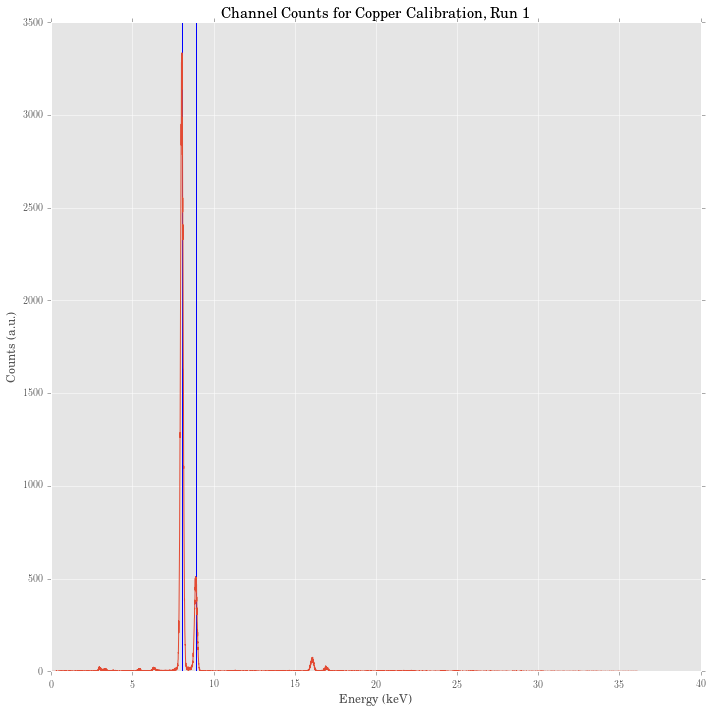

In [33]:
a = spectrograph('SumCrossXRF/Calibration/7Mar_Cu1.txt')
a.find_peaks(100, 20)
a.plot_spectrum('Copper Calibration, Run 1')
a.ax.vlines(a.peaks, 0, 3500, color = 'b')
# a.peaks
# np.poly1d(a.cal_fit_params)(100)

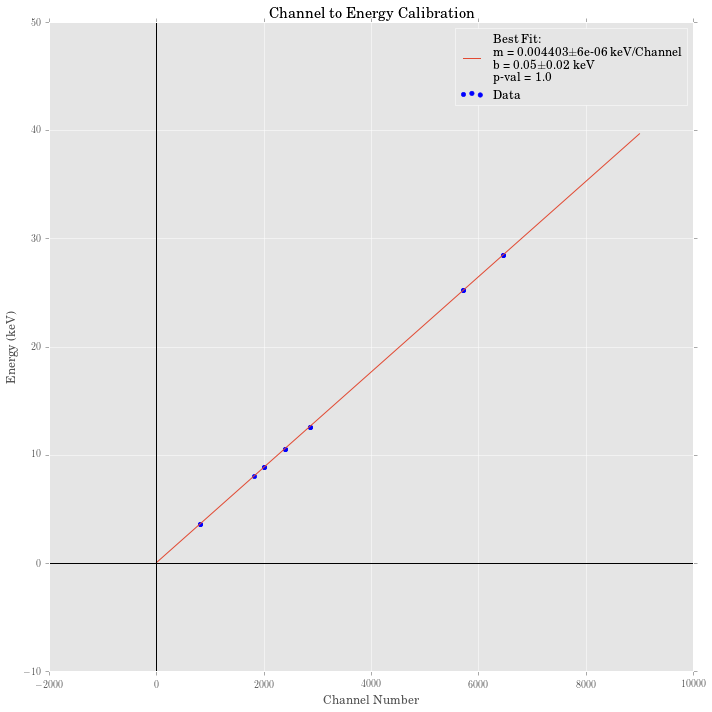

In [46]:
a.plot_calib()

In [64]:
test = spectrograph('SumCrossXRF/Calibration/7Mar_Cu1.txt')
# test.cal_good_fit()
# print(test.calm_report[1])
# test.plot_calib()
# test.file
# len(test.cal_energy)
# test.file['Energy (keV)']
# np.array(test.file['Counts'])

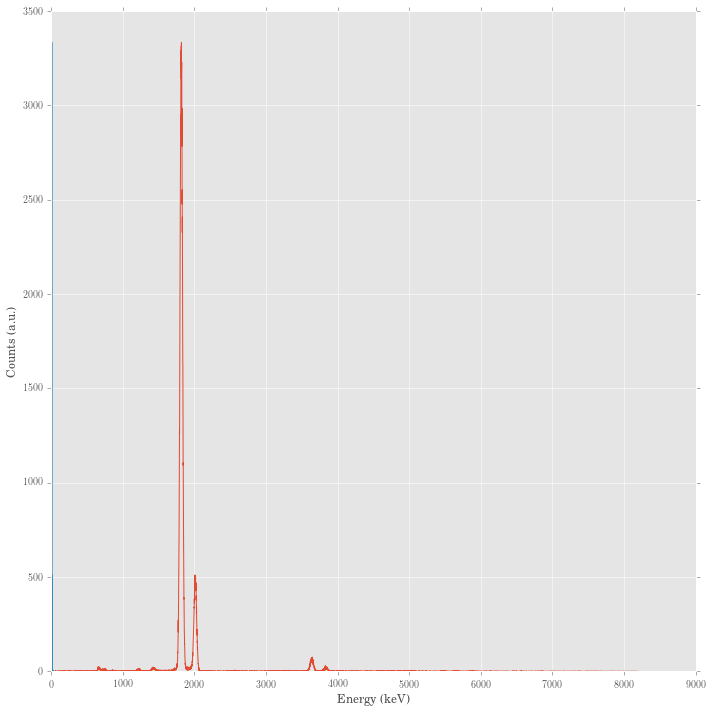

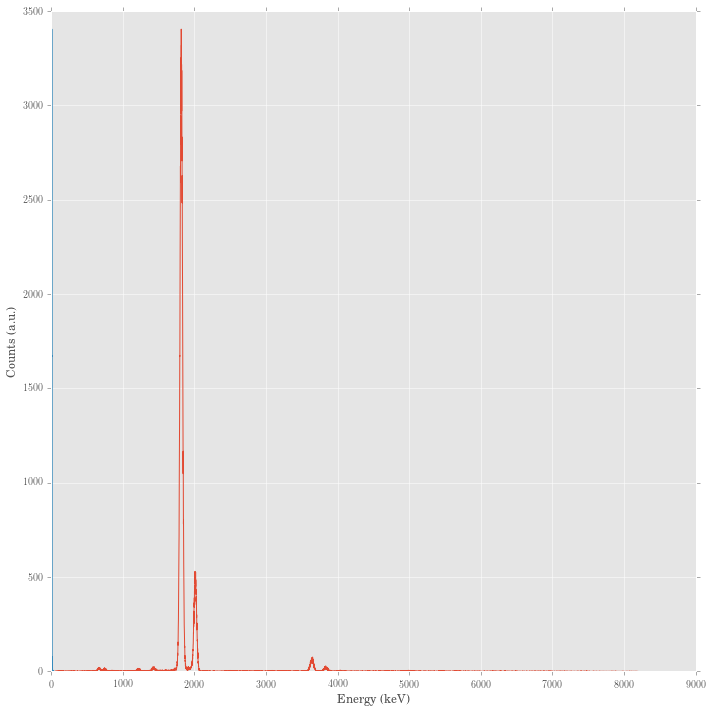

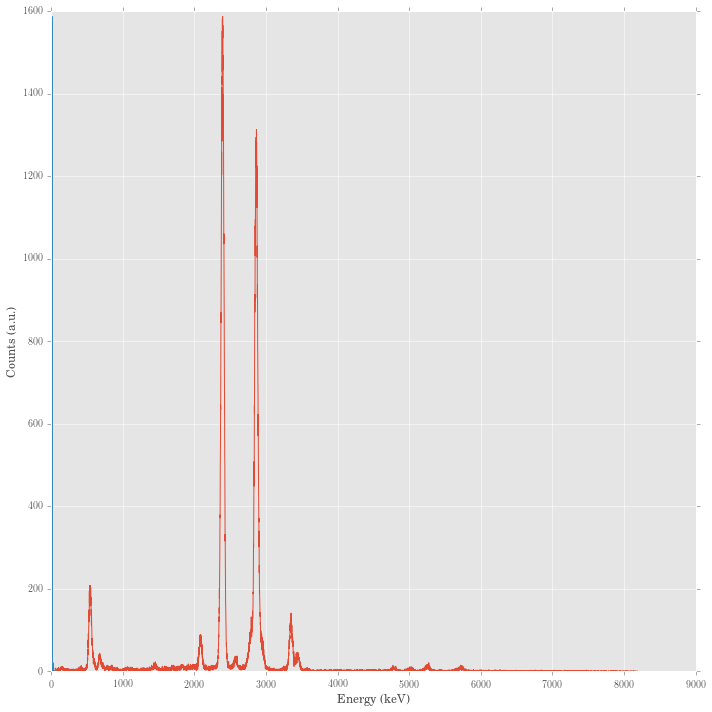

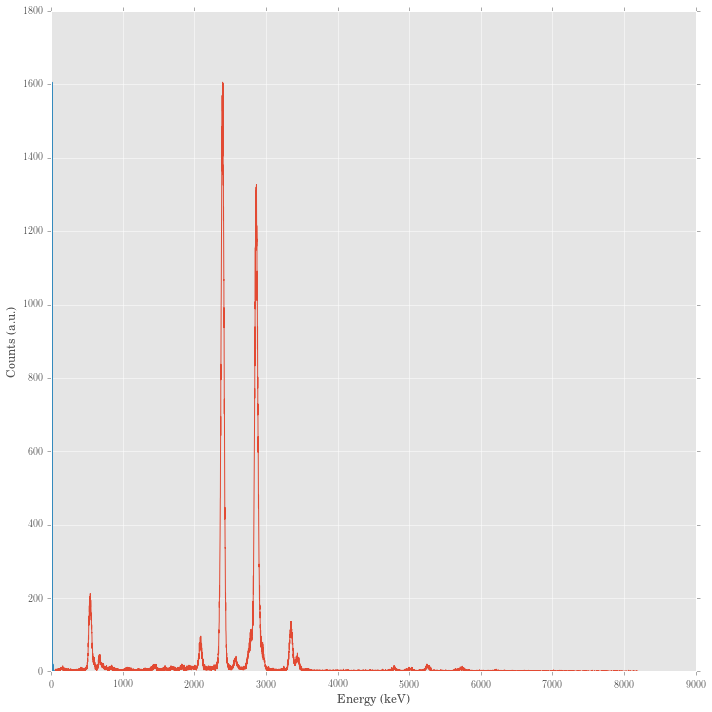

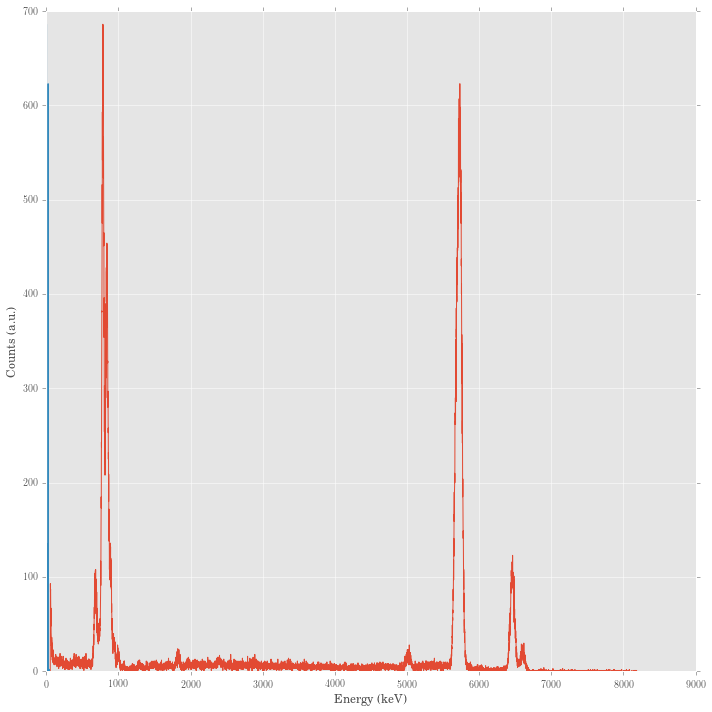

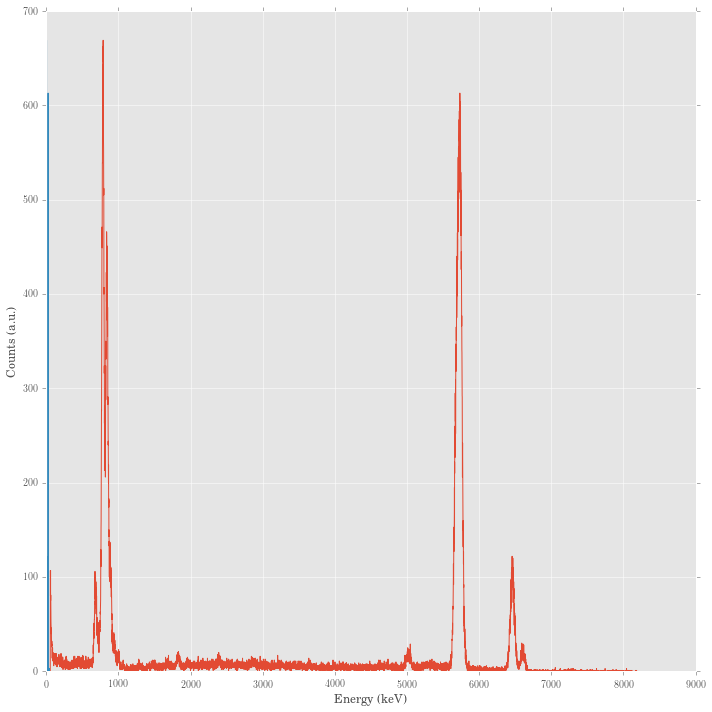

In [57]:
# Plot all calibration Runs
for file in sorted(os.listdir('SumCrossXRF/Calibration/')):
    spect = spectrograph('SumCrossXRF/Calibration/{}'.format(file))
    spect.plot_spectrum(file[5:7])

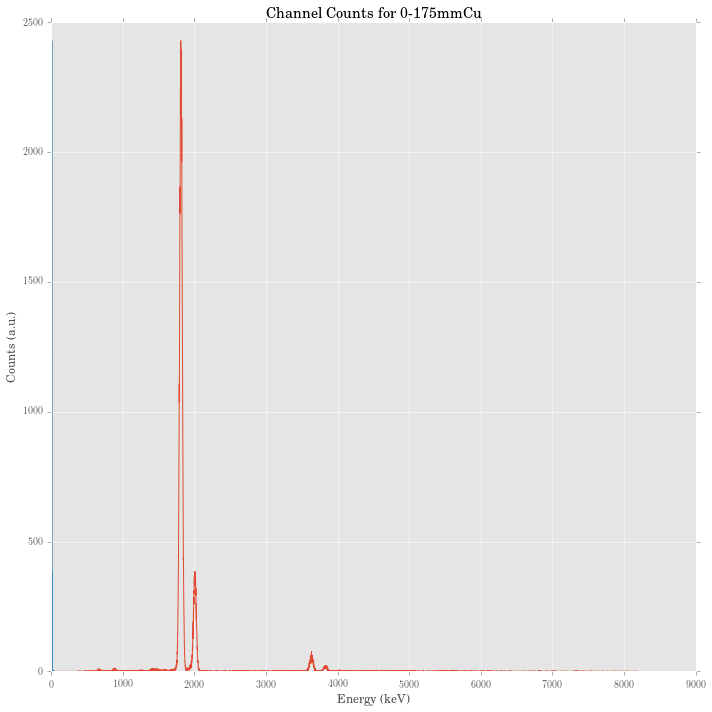

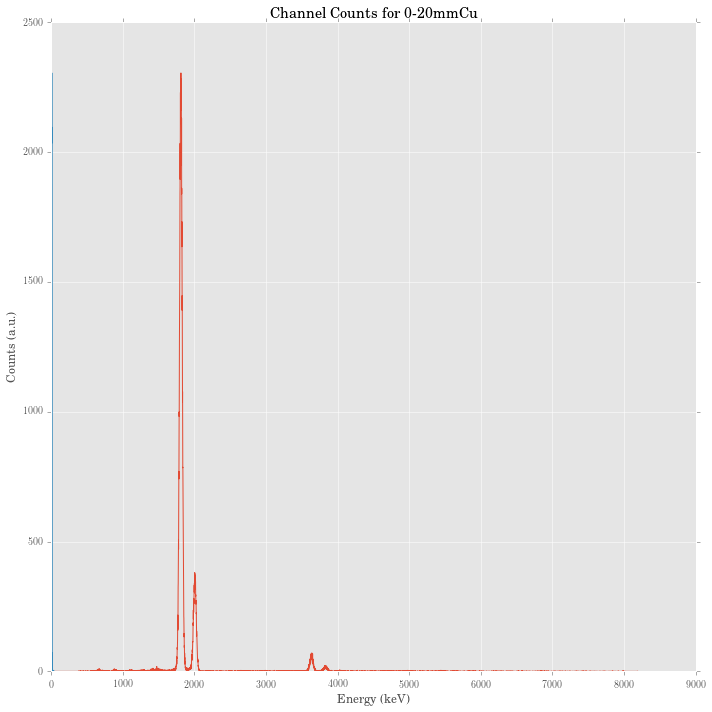

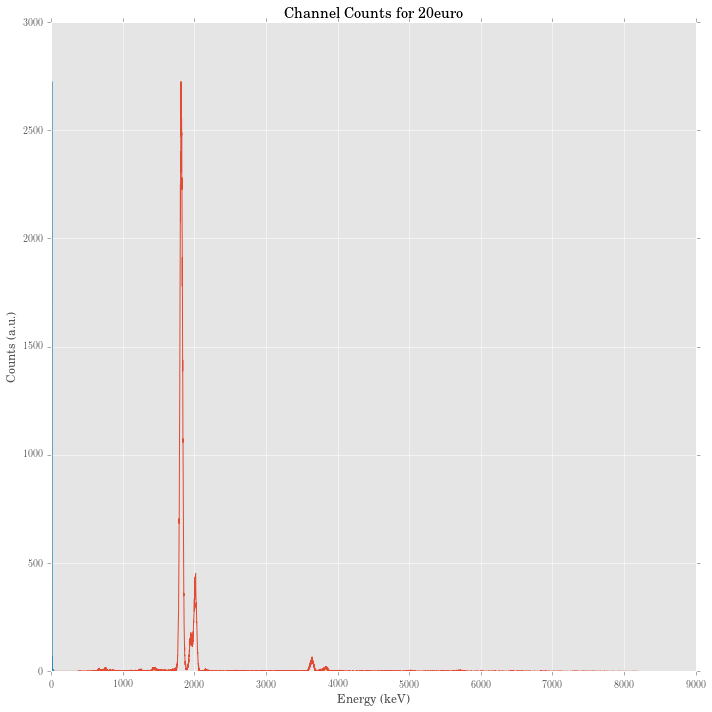

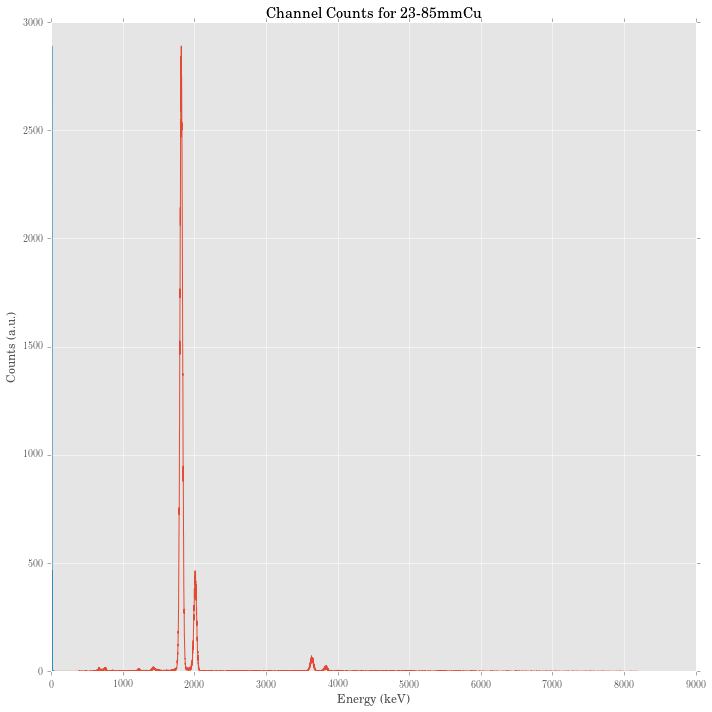

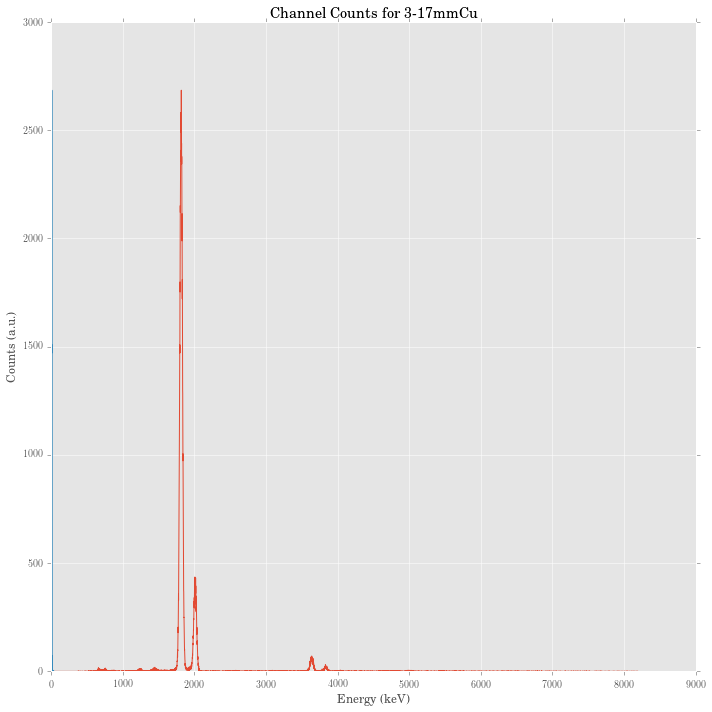

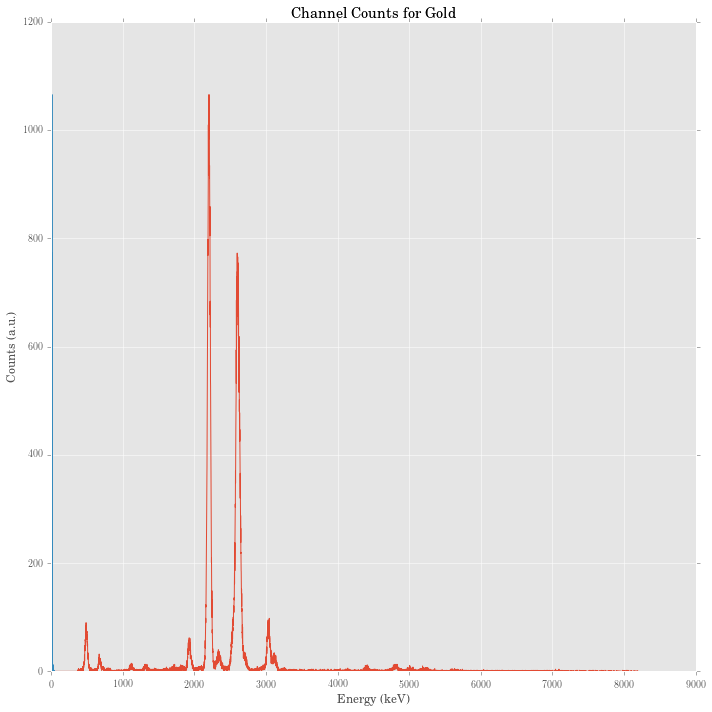

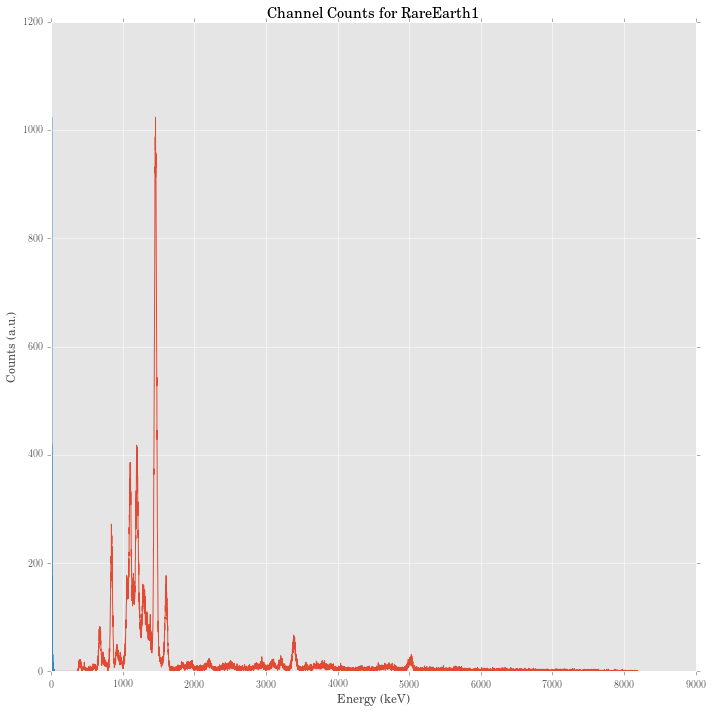

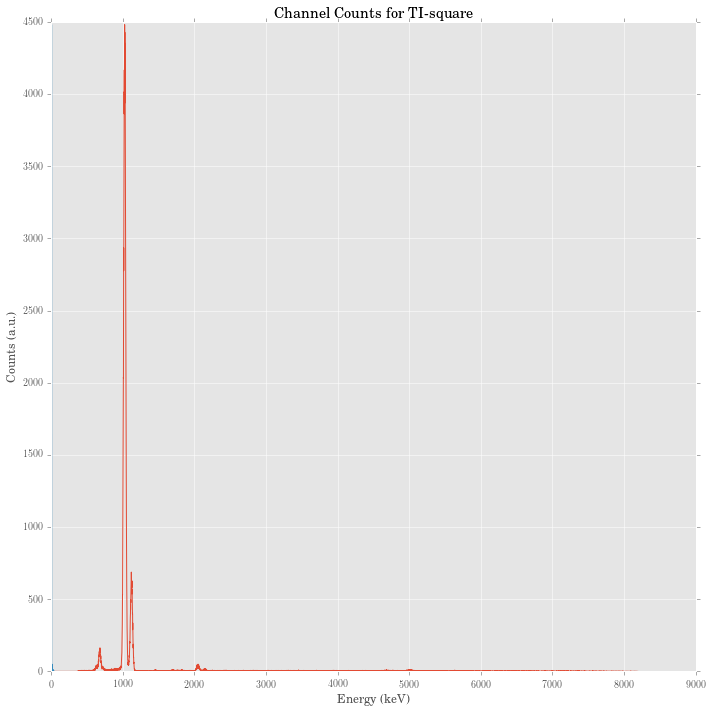

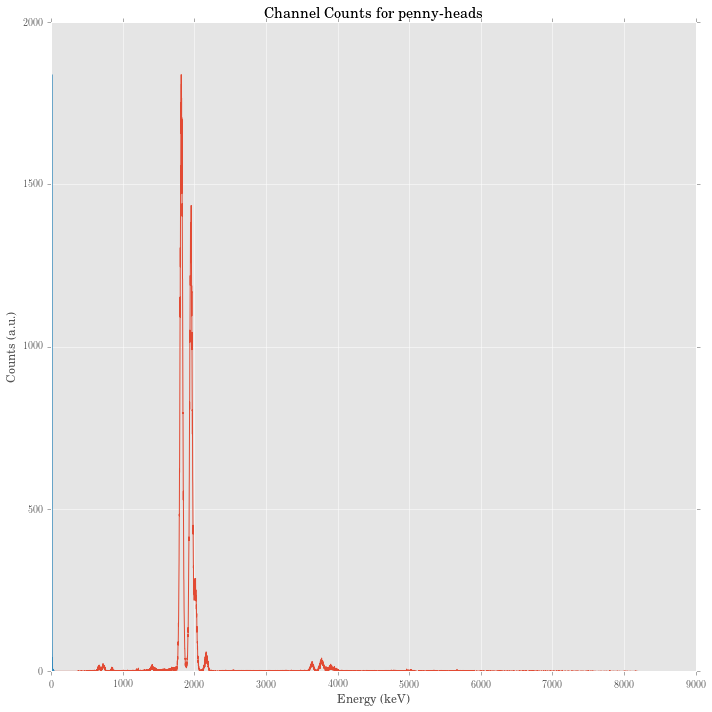

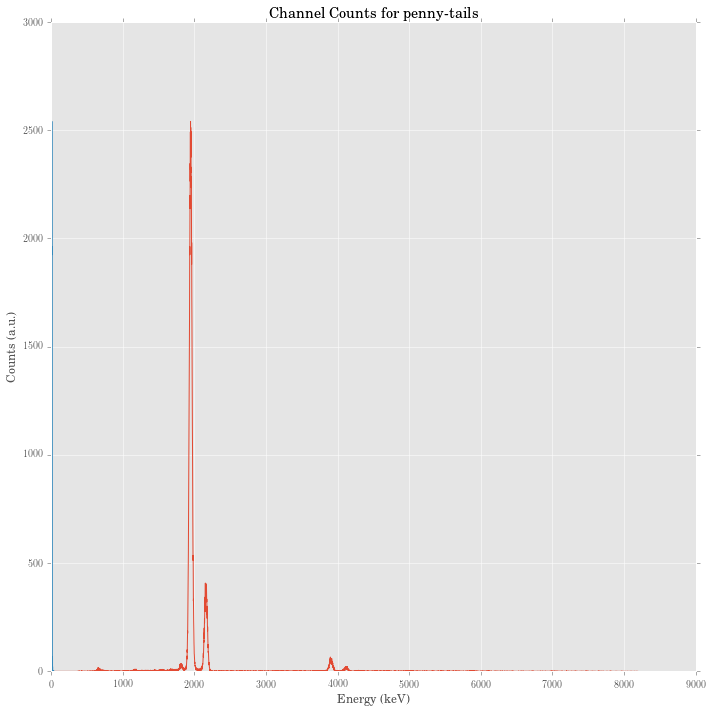

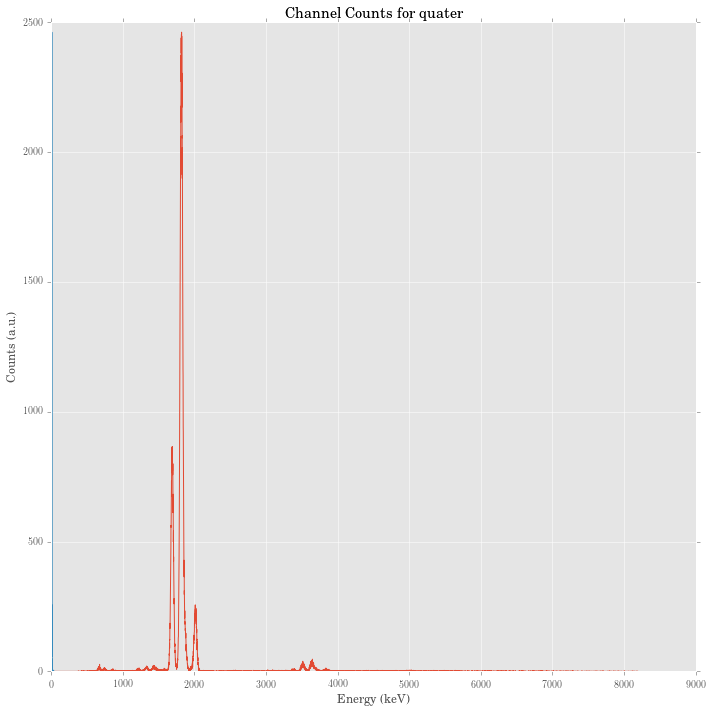

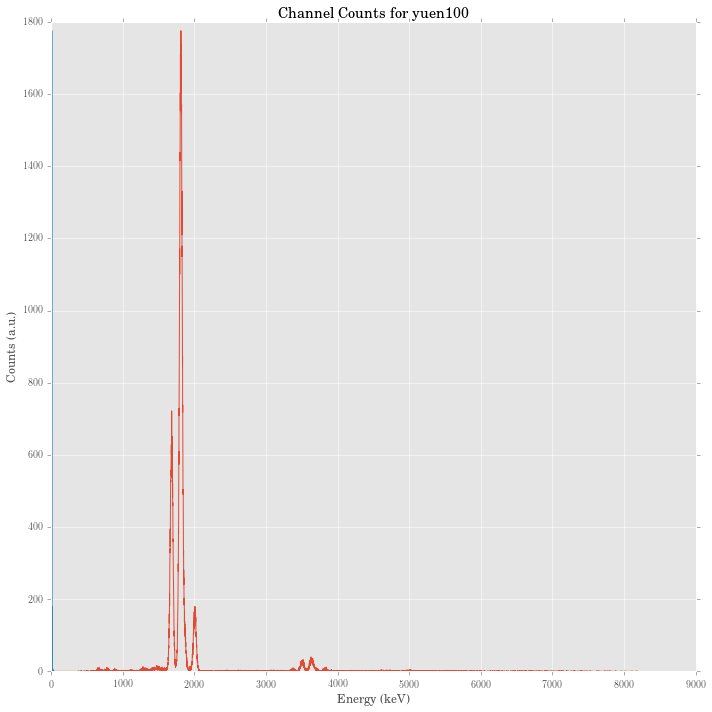

In [62]:
# Plot all Data Runs
for file in sorted(os.listdir('SumCrossXRF/Data/')):
#     print(file.partition('.')[0].partition('_')[2])
    spect = spectrograph('SumCrossXRF/Data/{}'.format(file))
    spect.plot_spectrum(file.partition('.')[0].partition('_')[2])

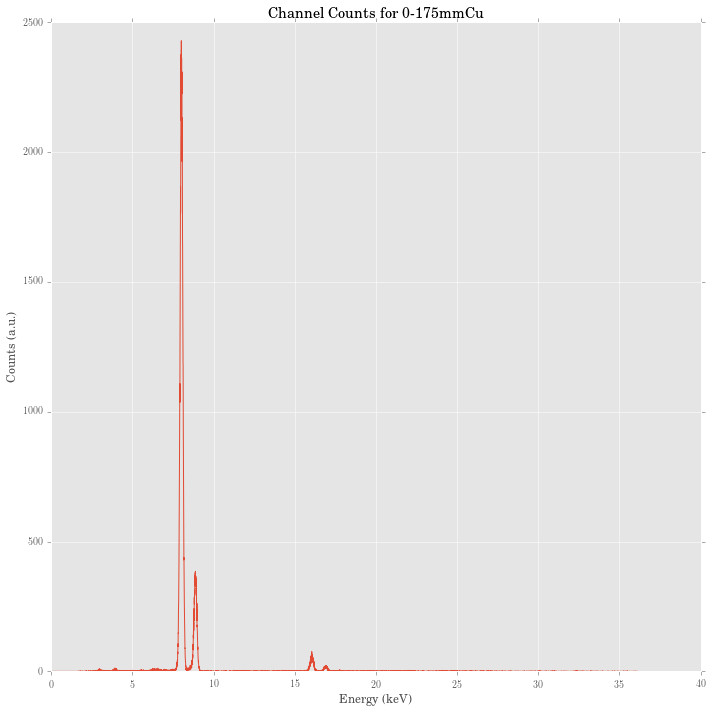

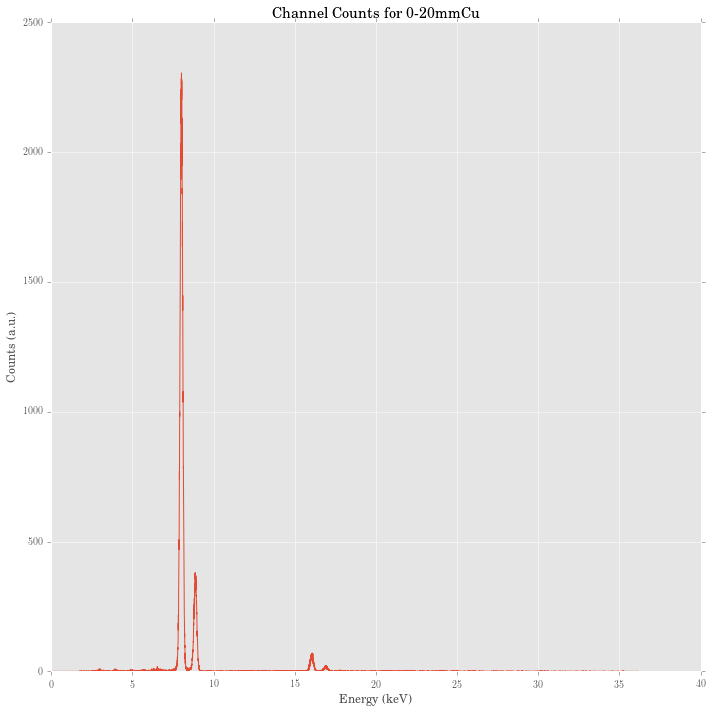

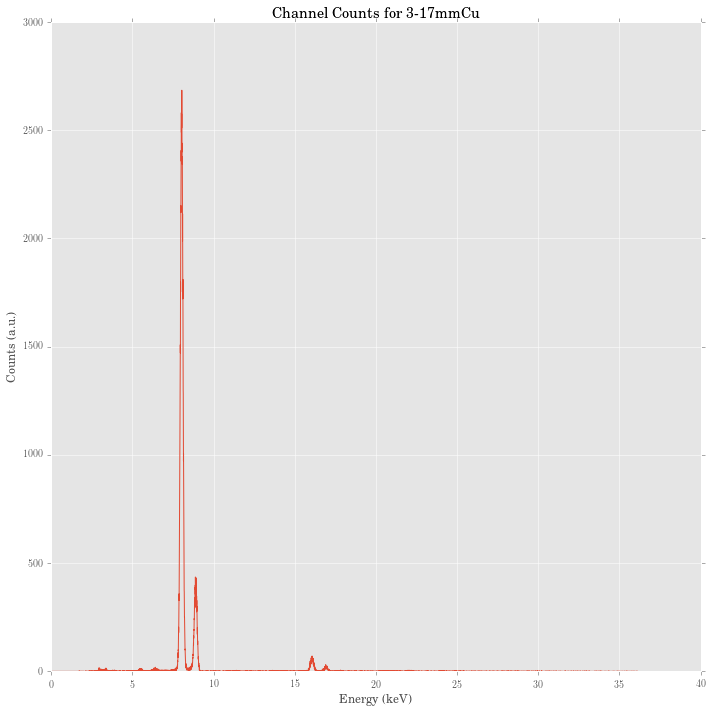

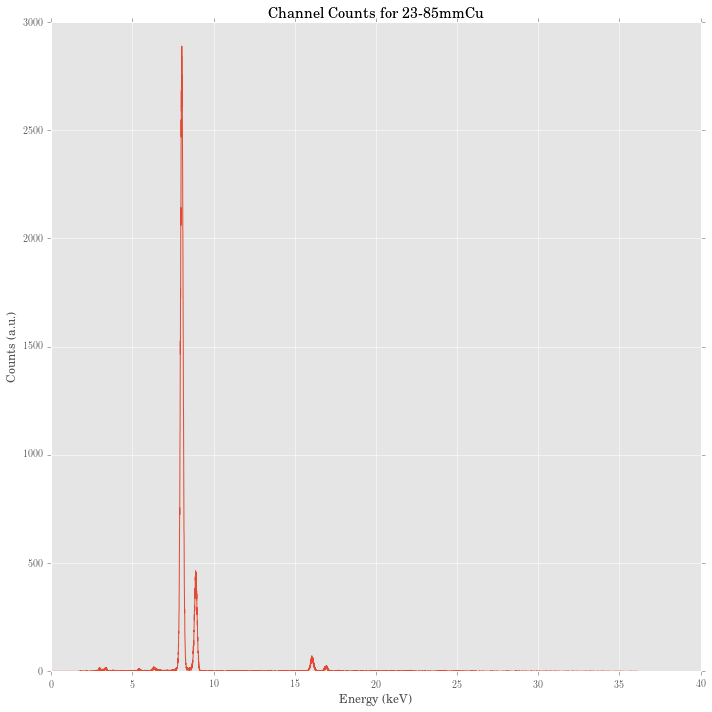

In [37]:
# Plot all copper data runs for width comparisons
for file in ['SumCrossXRF/Data/7Mar_0-175mmCu.txt', 'SumCrossXRF/Data/7Mar_0-20mmCu.txt', 'SumCrossXRF/Data/7Mar_3-17mmCu.txt','SumCrossXRF/Data/7Mar_23-85mmCu.txt']:
    spect = spectrograph(file)
    spect.plot_spectrum(file.partition('.')[0].partition('_')[2])

Goal:  Do a fitting:  If an element shows up in a material, *all* peaks should be showing up in the material spectrum.  Create the theoretical spectrum for each element by creating gaussians centered on the theoretical positions.  First, we parse data from http://www.med.harvard.edu/jpnm/physics/refs/xrayemis.html to get the location of all x-ray fluorescence peaks.  Then, we will use an arbitrary data run from the instrument to generate a plot of these peaks against the same bins as the instrument collected data.  We assume a gaussian fit for each peak.

In [38]:
wavelengths = pd.read_fwf('X-Ray_database', names = ['Z', 'Ka1', 'Ka2', 'Kb1', 'La1', 'La2', 'Lb1', 'Lb2',
       'Lg1'],index_col = 0, skiprows = 2, usecols = [0,2,3,4,5,6,7,8,9]).T
wavelengths=wavelengths.fillna(0.)
wavelengths=wavelengths.replace(['-','0'],0.)
wavelengths
for i in wavelengths:
    wavelengths[i] = wavelengths[i].astype(float)
wavelengths.columns.astype('int')
# len(wavelengths.columns)
wavelengths

Z,3,4,5,6,7,8,9,10,11,12,...,86,87,88,89,90,91,92,93,94,95
Ka1,0.0543,0.1085,0.1833,0.277,0.3924,0.5249,0.6768,0.8486,1.04098,1.2536,...,83.7800,86.1000,88.4700,90.8840,93.3500,95.8680,98.4390,0.0000,0.0000,0.0000
Ka2,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.8486,1.04098,1.2536,...,81.0700,83.2300,85.4300,87.6700,89.9530,92.2870,94.6650,0.0000,0.0000,0.0000
Kb1,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,1.07110,1.3022,...,94.8700,97.4700,100.1300,102.8500,105.6090,108.4270,111.3000,0.0000,0.0000,0.0000
La1,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,11.7270,12.0313,12.3397,12.6520,12.9687,13.2907,13.6147,13.9441,14.2786,14.6172
La2,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,11.5979,11.8950,12.1962,12.5008,12.8096,13.1222,13.4388,13.7597,14.0842,14.4119
Lb1,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,14.3160,14.7700,15.2358,15.7130,16.2022,16.7020,17.2200,17.7502,18.2937,18.8520
Lb2,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,0.0000,14.4500,14.8414,0.0000,15.6237,16.0240,16.4283,16.8400,17.2553,17.6765
Lg1,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.00000,0.0000,...,16.7700,17.3030,17.8490,18.4080,18.9825,19.5680,20.1671,20.7848,21.4173,22.0652


In [63]:
spectral_data[spectral_data.columns[1:]];

In [48]:
@interact(x0 = (0,9000,50), σ = (0,1000,20),  continuous_update=False)
def make_peak(x0, σ):
    x = np.linspace(0, 9000,9000)
    y = σ*np.sqrt(2*np.pi)*norm.pdf(x, loc = x0, scale = σ)
    fig, ax = plt.subplots(figsize = (8,8))
    ax.plot(x,y)
    fig.tight_layout()

interactive(children=(IntSlider(value=4500, description='x0', max=9000, step=50), IntSlider(value=500, description='σ', max=1000, step=20), Output()), _dom_classes=('widget-interact',))

In [41]:
# Create a dataset of the spectrum discretized into the same size as the instrument collected data
def make_spectrum(x, wavelengths, σ):
    spectrum = np.zeros(len(x))
    for x0 in wavelengths:
        add = σ*np.sqrt(2*np.pi)*norm.pdf(x, loc = x0, scale = σ)
        if (x0 <1.5 or x0>25.):
            spectrum += .01*σ*np.sqrt(2*np.pi)*norm.pdf(x, loc = x0, scale = σ)
        else:
            spectrum += σ*np.sqrt(2*np.pi)*norm.pdf(x, loc = x0, scale = σ)
    return spectrum

# x = np.linspace(0,40,9000)
# # .5*np.sqrt(2*np.pi)*norm.pdf(x, loc = )
# fig, ax = plt.subplots(figsize = (10,10))
# ax.plot(x, make_spectrum(x, wavelengths[87], .1))

spectral_data = {}
for column in wavelengths:
    spectral_data[column] = make_spectrum(test.file['Energy (keV)'],wavelengths[column], .1)

spectral_data = pd.DataFrame(spectral_data)
spectral_data.insert(0,'Energy (keV)',test.file['Energy (keV)'])
spectral_data
# len(spectral_data)

# fig, ax = plt.subplots()
# ax.plot(spectral_data['Energy (keV)'],spectral_data[29])
# spectral_data[5]

,Energy (keV),3,4,5,6,7,8,9,10,11,...,86,87,88,89,90,91,92,93,94,95
0,0.045407,0.073104,0.071338,0.067008,0.063828,0.063167,0.063143,0.063143,0.054123,0.045102,...,0.009020,0,0,0.009020,0,0,0,0.027061,0.027061,0.027061
1,0.049811,0.071823,0.070251,0.065936,0.062590,0.061861,0.061833,0.061833,0.053000,0.044167,...,0.008833,0,0,0.008833,0,0,0,0.026500,0.026500,0.026500
2,0.054214,0.070433,0.069063,0.064780,0.061269,0.060466,0.060433,0.060433,0.051800,0.043167,...,0.008633,0,0,0.008633,0,0,0,0.025900,0.025900,0.025900
3,0.058617,0.068941,0.067781,0.063547,0.059872,0.058989,0.058951,0.058950,0.050529,0.042107,...,0.008421,0,0,0.008421,0,0,0,0.025264,0.025264,0.025264
4,0.063020,0.067355,0.066410,0.062244,0.058406,0.057437,0.057393,0.057393,0.049194,0.040995,...,0.008199,0,0,0.008199,0,0,0,0.024597,0.024597,0.024597
5,0.067424,0.065682,0.064959,0.060878,0.056880,0.055819,0.055768,0.055768,0.047801,0.039834,...,0.007967,0,0,0.007967,0,0,0,0.023900,0.023900,0.023900
6,0.071827,0.063932,0.063434,0.059456,0.055303,0.054143,0.054084,0.054084,0.046358,0.038631,...,0.007726,0,0,0.007726,0,0,0,0.023179,0.023179,0.023179
7,0.076230,0.062112,0.061842,0.057987,0.053682,0.052417,0.052350,0.052349,0.044871,0.037392,...,0.007478,0,0,0.007478,0,0,0,0.022435,0.022435,0.022435
8,0.080634,0.060232,0.060192,0.056476,0.052027,0.050650,0.050573,0.050572,0.043348,0.036123,...,0.007225,0,0,0.007225,0,0,0,0.021674,0.021674,0.021674
9,0.085037,0.058300,0.058489,0.054932,0.050345,0.048850,0.048762,0.048761,0.041795,0.034829,...,0.006966,0,0,0.006966,0,0,0,0.020898,0.020898,0.020898


We wish to find an expression
\begin{equation}
A_3*\text{Spectrum}(Z=3) + A_4*\text{Spectrum}(Z=4) + ... + A_{95}*\text{Spectrum}(Z=95) = \text{Spectrum}(Data)
\end{equation}
such that the $A_i$ represents how much of the $Z = i$ is present in the sample.
We have an abundance of data, as each point represents a value that, as a scalar, must satisfy the above equation.  Thus we convert this equation into its matrix form $\mathbf{A}\vec{x}=\vec{b}$.  Each column of the above matrix (dataframe) represents the column of the coefficient matrix, $\vec{x}$ is the column vector with elements $A_i$, and $\vec{b}$ is the column vector describing the data obtained.

Because we have an overdetermined system, we do a linear least squares fitting to find the best 'fit'.  However, we must add the constraint that $A_i>=0$, since we can't have spectral subtraction.  For this, we use FORTRAN's non-negative least squares solver, implemented in scipy.optimize.nnls

In [42]:
Z_dict = pd.read_fwf('X-Ray_database', names = ['Z', 'Element'],index_col = 0, skiprows = 2, usecols = [0,1])
# Z_dict['Element'].astype('str')
# print(Z_dict.iloc[16])
Z_dict.iloc[8]['Element']
Z_dict

,Element
Z,
3,Li
4,Be
5,B
6,C
7,N
8,O
9,F
10,Ne
11,Na


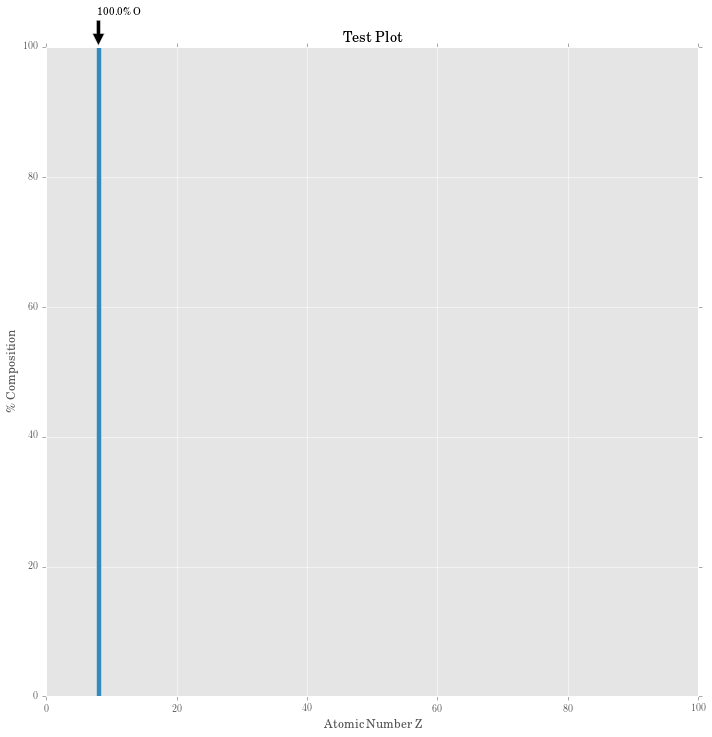

In [43]:
A = spectral_data[spectral_data.columns[1:]].as_matrix()

def composition(data):
    comps, resid = optimize.nnls(A,data)
    comps /= np.sum(comps)
    return comps, resid

def plot_composition(data, title, threshold):
    comps = composition(data)[0]
    important_idx = np.where(comps>threshold)[0]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(np.linspace(3,95, 93), comps*100, align = 'center')
    ax.set_xlabel('Atomic Number Z')
    ax.set_ylabel('\% Composition')
    for i in important_idx:
        ax.annotate('{:.1f}\% {}'.format(comps[i]*100, Z_dict.iloc[i]['Element']),\
                    xy = (i+3,comps[i]*100), xytext = (i+3,comps[i]*100+5),\
                    arrowprops=dict(facecolor='black', shrink=0.05) )
    ax.set_title(title)
    fig.tight_layout()
    

# Lets test this on the known spectrum for various elements as given by the website referenced above

plot_composition(spectral_data[8], 'Test Plot', .02)
# plot_composition(spectrograph('SumCrossXRF/Calibration/7Mar_Cu1.txt').get_counts(),'Copper Calibration (Data)')
# plot_composition(spectrograph('SumCrossXRF/Data/7Mar_Gold.txt').get_counts(),'Gold Foil',.01)

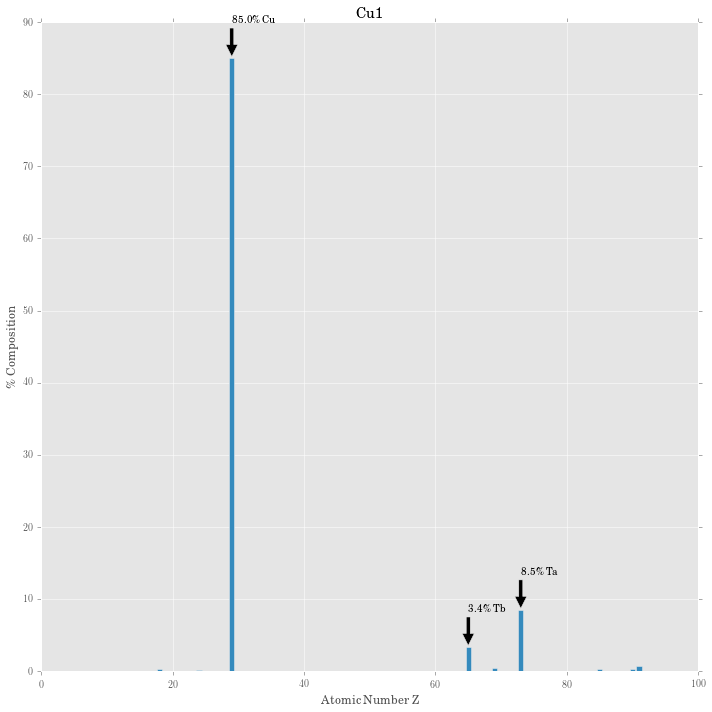

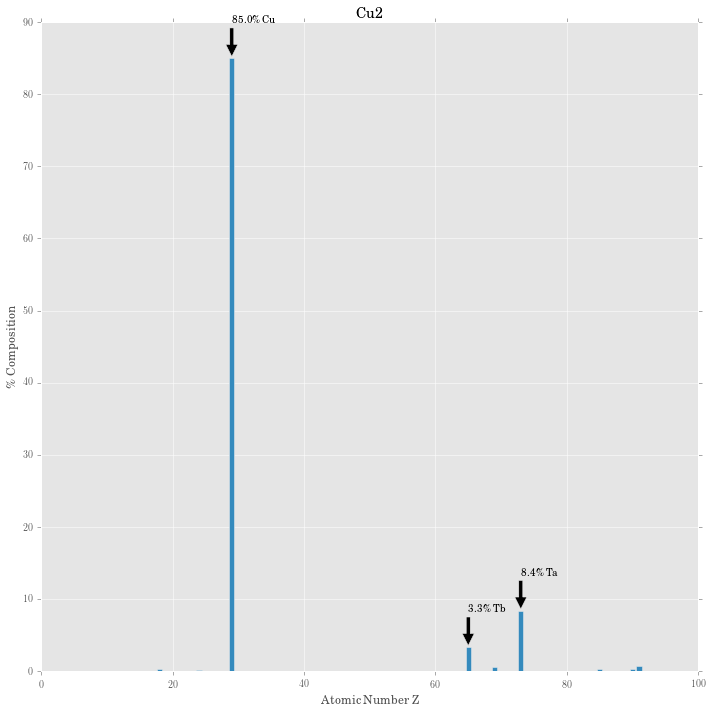

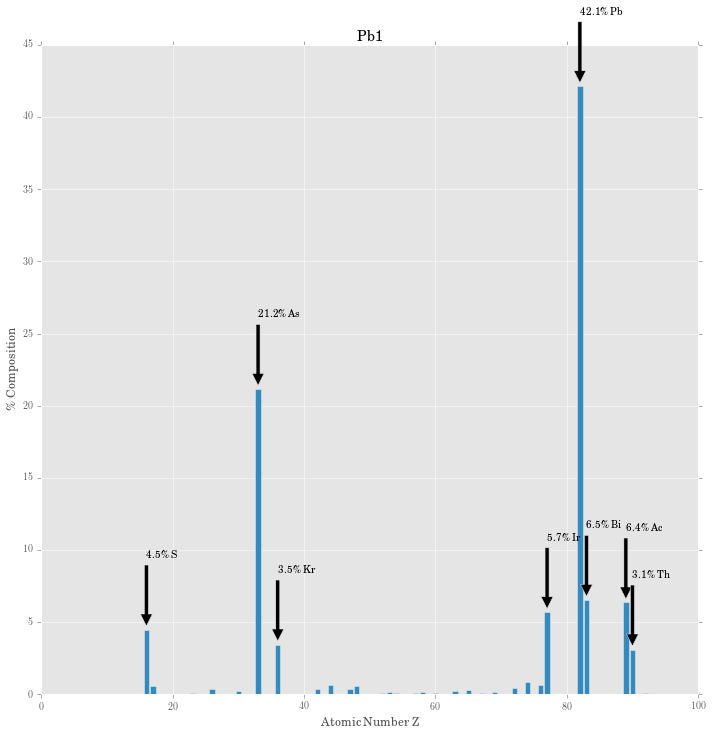

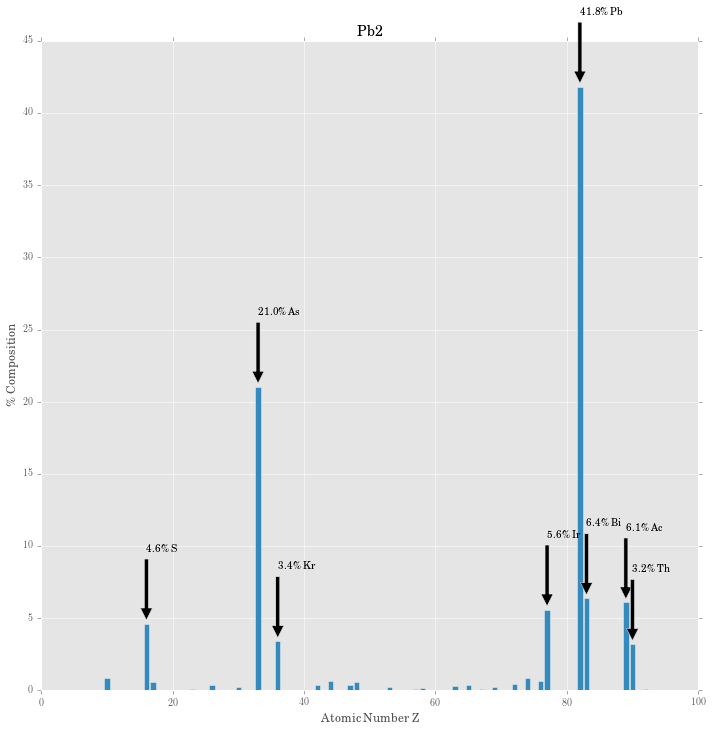

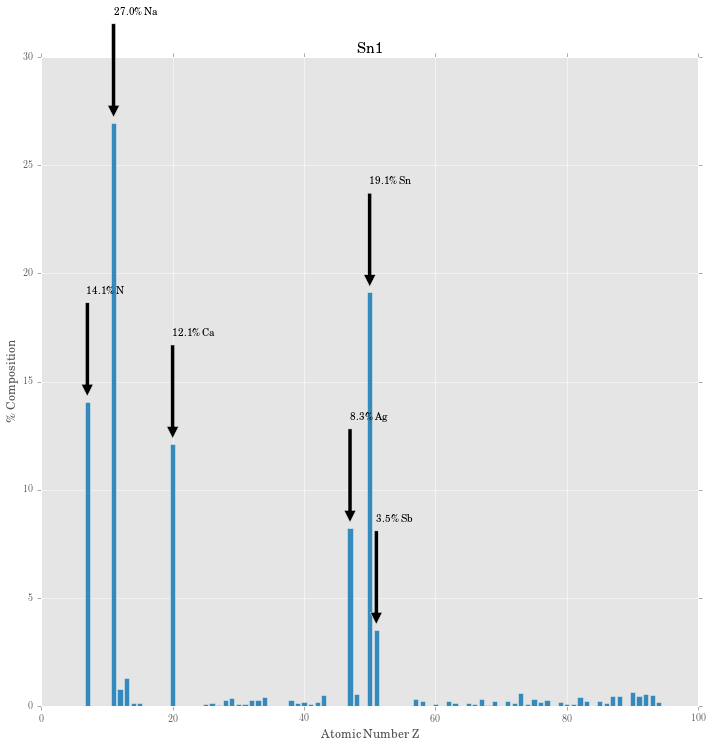

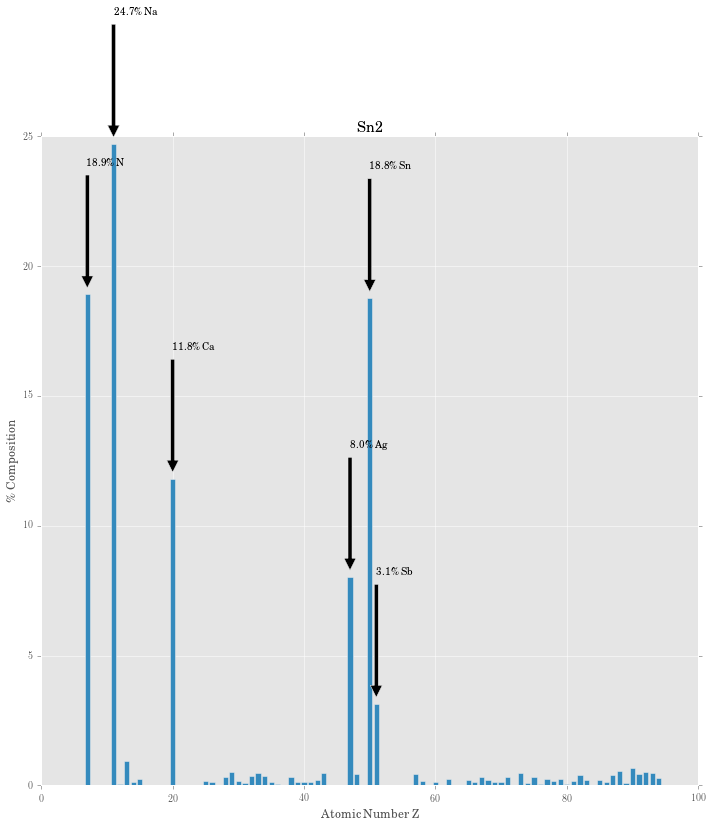

In [59]:
# Now lets look at the composition of all the data runs
for file in sorted(os.listdir('SumCrossXRF/Calibration/')):
#     print(file.partition('.')[0].partition('_')[2])
    spect = spectrograph('SumCrossXRF/Calibration/{}'.format(file))
    plot_composition(spect.get_counts(),file.partition('.')[0].partition('_')[2],.02)

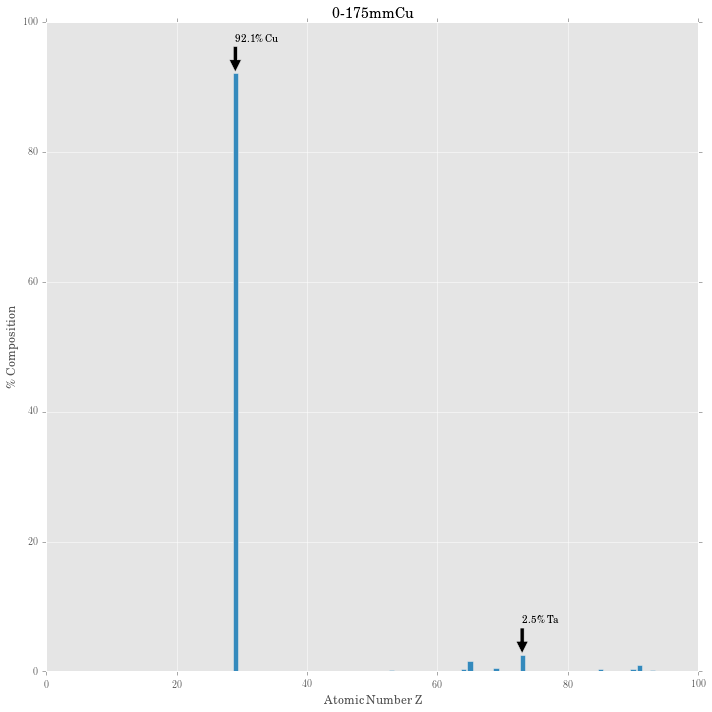

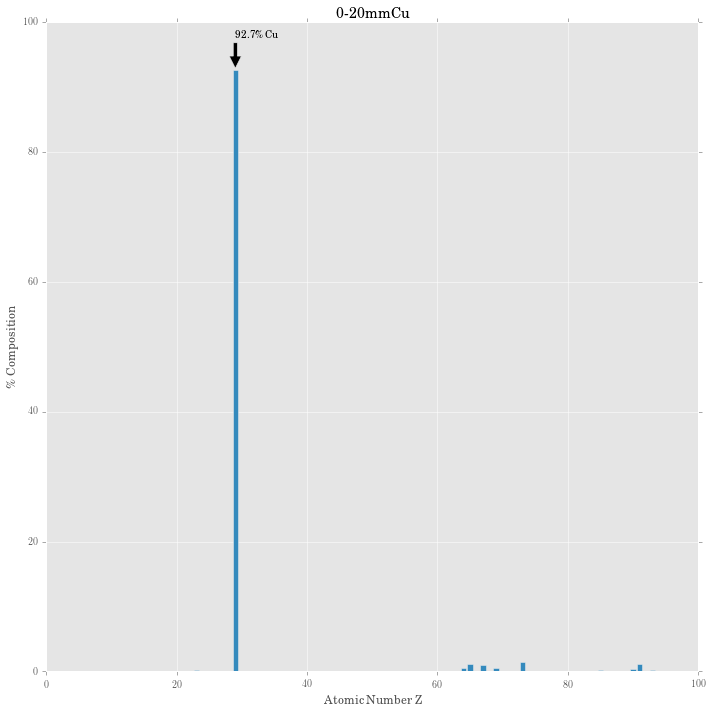

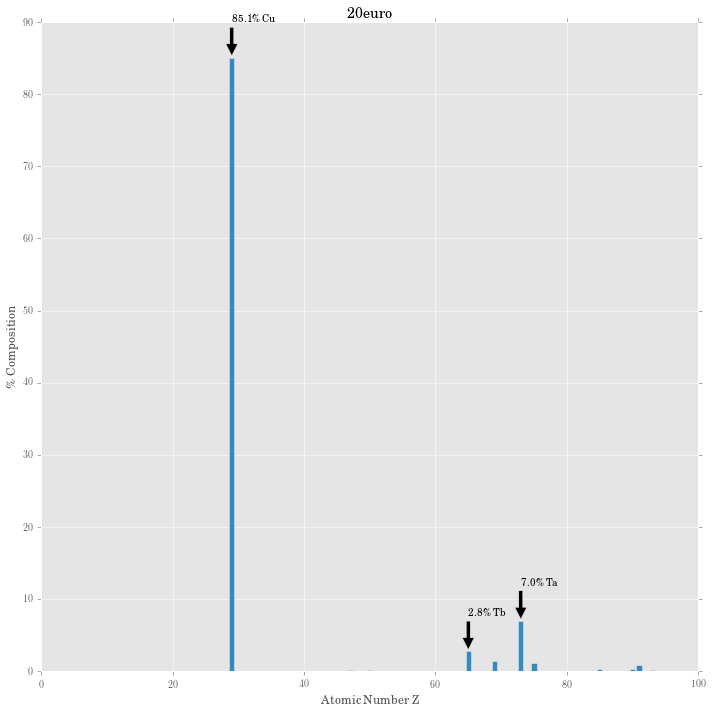

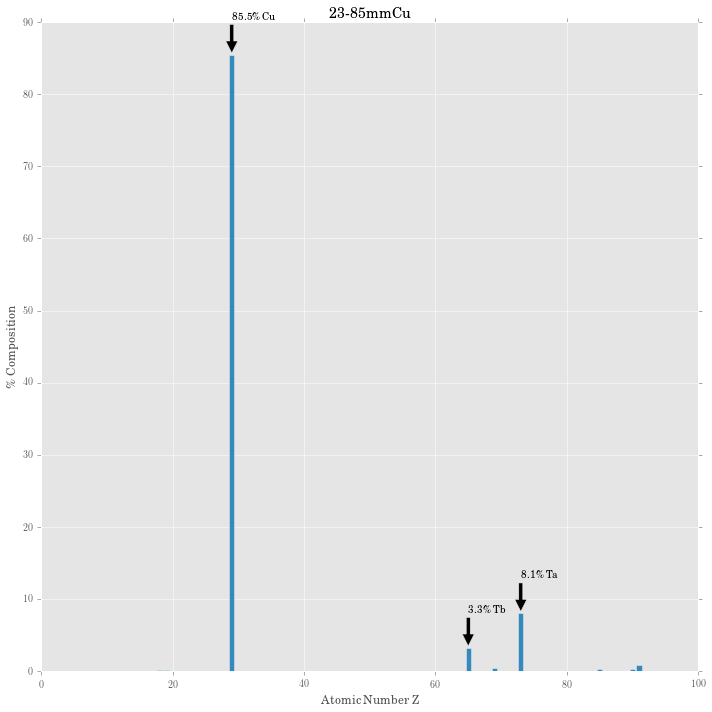

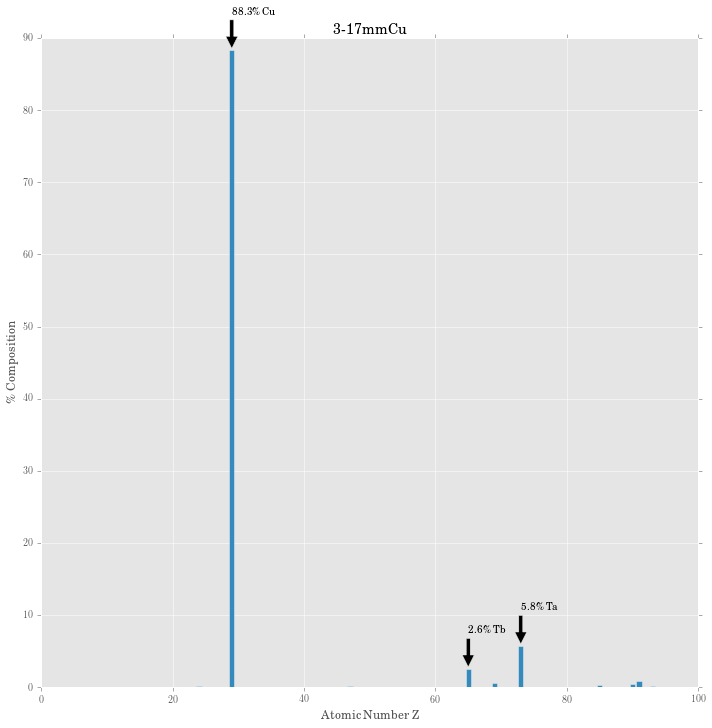

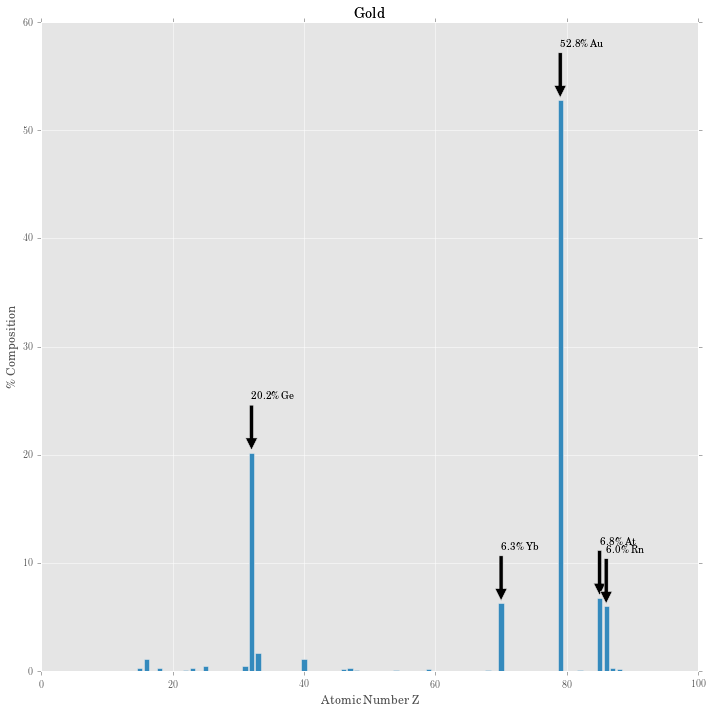

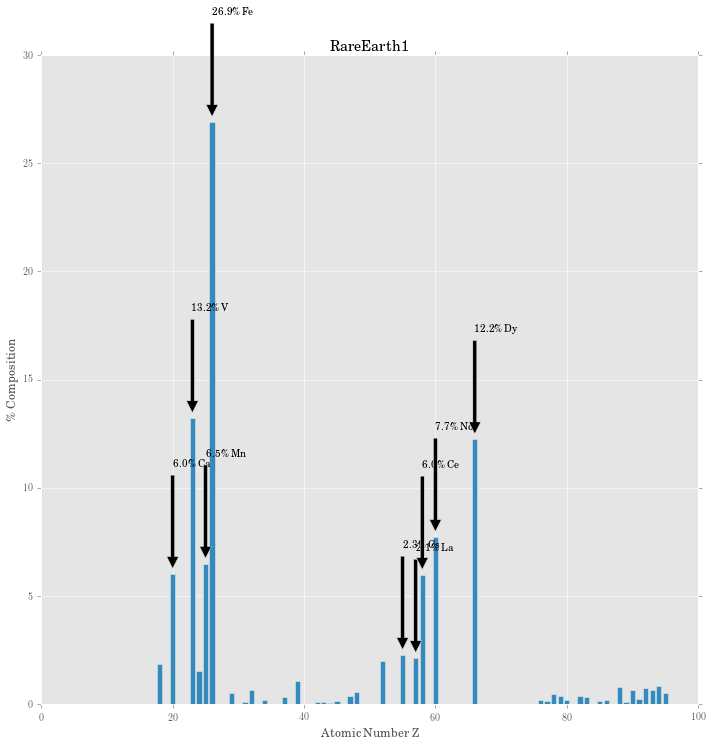

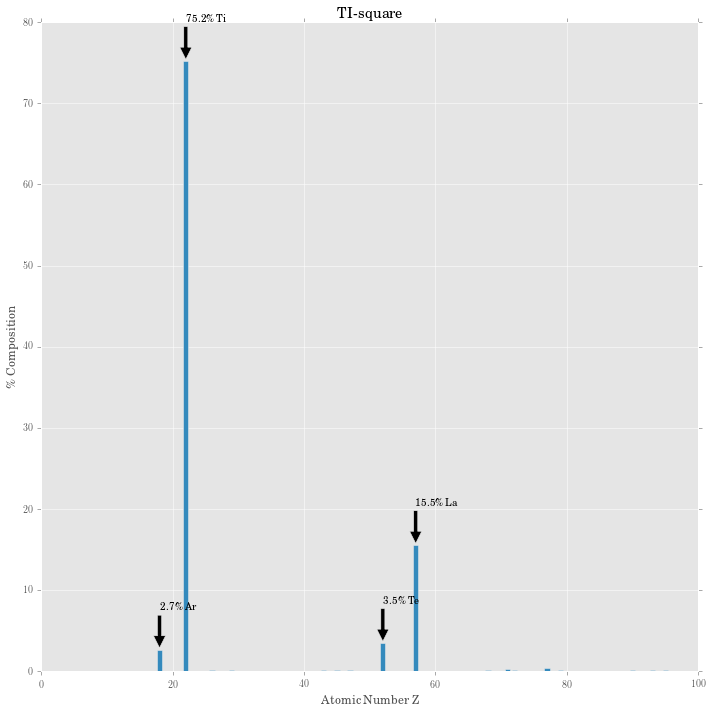

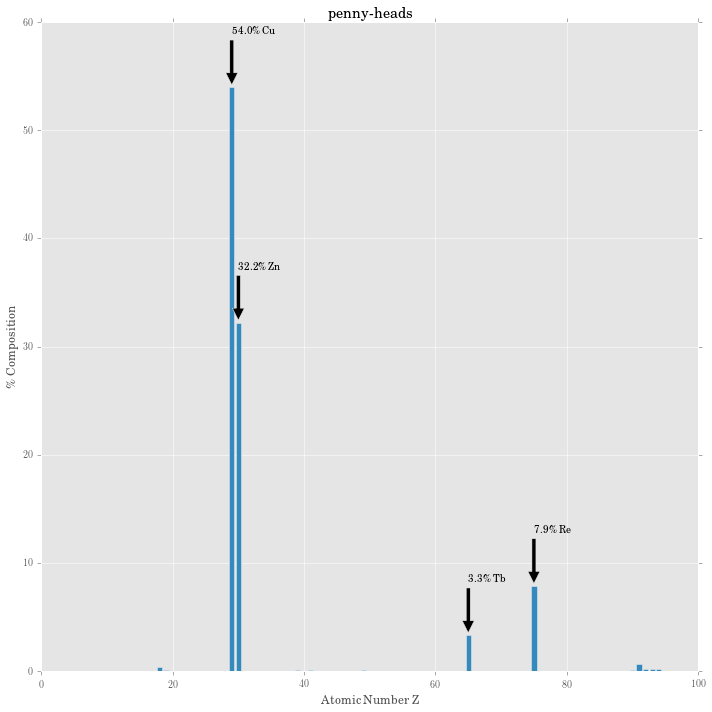

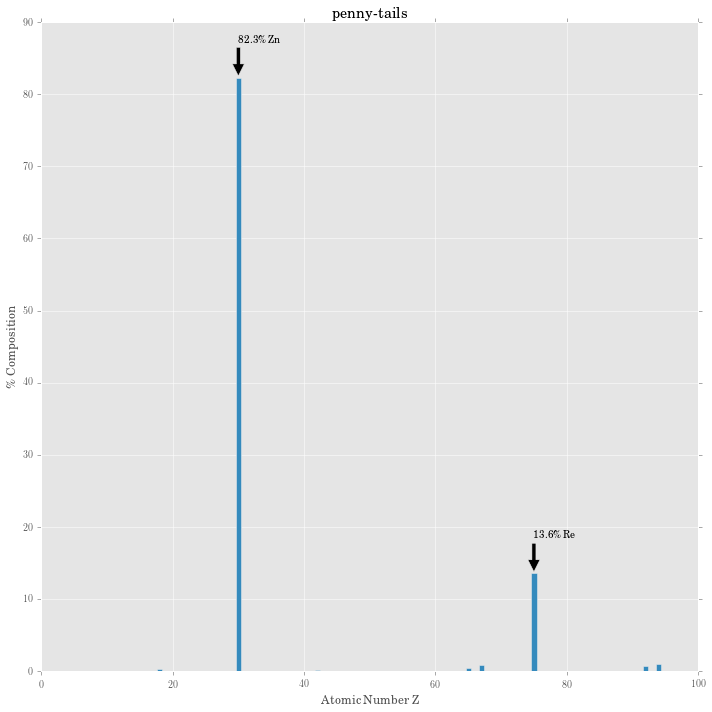

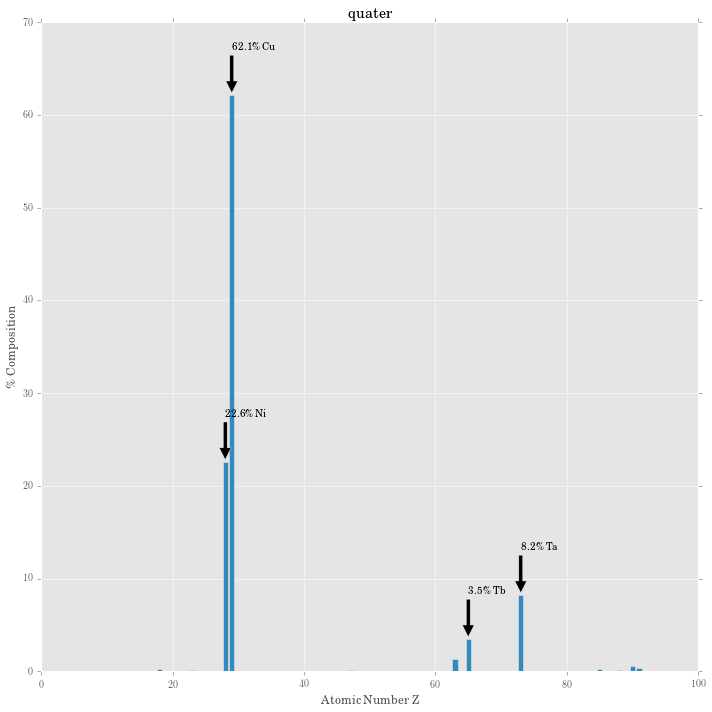

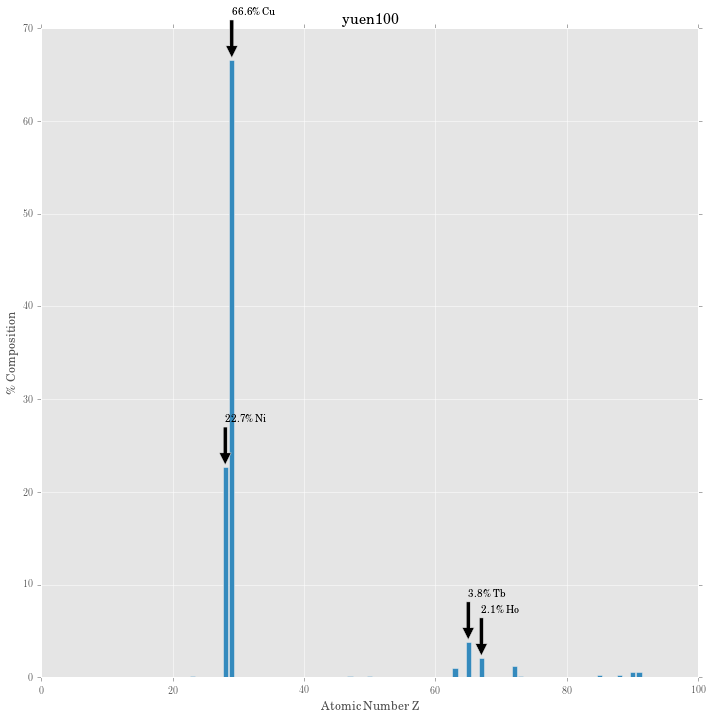

In [44]:
# Now lets look at the composition of all the data runs
for file in sorted(os.listdir('SumCrossXRF/Data/')):
#     print(file.partition('.')[0].partition('_')[2])
    spect = spectrograph('SumCrossXRF/Data/{}'.format(file))
    plot_composition(spect.get_counts(),file.partition('.')[0].partition('_')[2],.02)

Clearly, there are some populations in the composition that make me question the fit.  For example, in the tin calibration samples, the dominant signal comes from sodium, which is more likely a false artefact from the data, as the sample seemed to be a reasonably well refined material.